In [1]:
import pandas as pd
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import ee
from functools import reduce
from sklearn.mixture import GaussianMixture
import numpy as np

pd.options.plotting.backend = "plotly"

In [2]:
geo_url = 'https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Oeffentlich_zugaengliche_Strassenparkplaetze_OGD?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=view_pp_ogd'

with urlopen(geo_url) as response:
    geo_data = json.load(response)

df = pd.json_normalize(geo_data, "features")

df["lon"] = df["geometry.coordinates"].apply(lambda row: row[0])
df["lat"] = df["geometry.coordinates"].apply(lambda row: row[1])

In [3]:
# ee.Authenticate()
ee.Initialize()
dataset = ee.ImageCollection("SKYSAT/GEN-A/PUBLIC/ORTHO/MULTISPECTRAL") 
# dataset = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") 
# dataset = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
# dataset = ee.ImageCollection("COPERNICUS/S1_GRD").select("angle")

In [4]:
def process_point(coords, scale=2, buffer=False):
    lon, lat = coords
    if buffer:
        poi = ee.Geometry.Point(lon, lat).buffer(buffer)
    else:
        poi = ee.Geometry.Point(lon, lat)

    ts = dataset.getRegion(poi, scale).getInfo()

    df = pd.DataFrame(ts[1:], columns=ts[0])
    df = df.dropna()
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    return df

test = df["geometry.coordinates"][0:10].apply(lambda row: process_point(row))
test = reduce(lambda x, y: pd.concat([x, y]), test)

In [13]:
# sns.histplot(data = test2, x = "angle", bins=90)

# sns.pairplot(test2[[f"B{i}" for i in range(1, 9)] + ["B8A", "B9", "B11", "B12"]], kind="hist")

# grouped = test2.groupby(["longitude", "latitude"])

# fig = go.Figure()
# for name, group in grouped:
#     fig.add_scatter(name = str(name), x = group["B2"], y = group["B3"], mode="markers")

# fig.update_layout(
#     height=600,
#     width=900
# )

# fig.show()

<AxesSubplot: xlabel='B', ylabel='Count'>

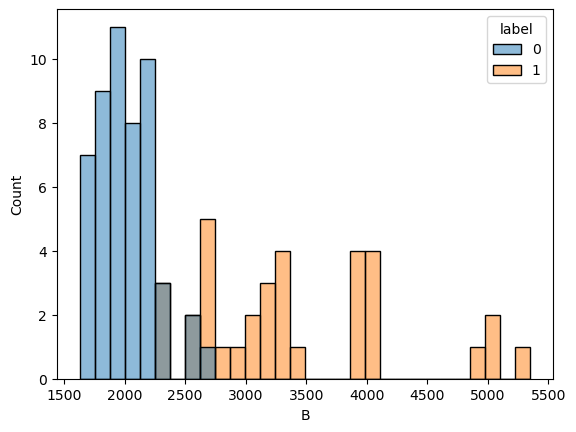

In [7]:
num_test = test[["B", "G", "R", "N", "P"]]
# test3 = test2[[f"B{i}" for i in range(1, 4)]]
res = GaussianMixture(n_components=2, covariance_type="full").fit(num_test)
test["label"] = res.predict(num_test)
sns.histplot(data=test, x="B", hue="label", bins=30)